Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import f_oneway

# Get data

In [2]:
filename = '110524.csv'

dfin = pd.read_csv(filename)
#encode gender as a 0/1
df = pd.get_dummies(dfin, columns=['gender'])
#store the language labels separately
langdata = df[['language']]
df = pd.get_dummies(df, columns=['language'])

#drop the empty column at the beginning
df = df.drop('Unnamed: 0',axis = 1)



#remove categorical columns except the column of interest, one gender
droplist= ['file_name', 'gender_M', 'sample_rate', 'bit_depth'] #since gender M is 100% linearly dependent of gender F and the technical stuff is not relevant
df = df.drop(droplist, axis=1)

#separate out the known labels from the predictors
labcol = ['emotion']
labels = df[labcol]
features = df.drop(labcol, axis=1)

print(labels)
print(features)


     emotion
0        ANG
1        SAD
2        ANG
3        SAD
4        ANG
...      ...
2528     HAP
2529     HAP
2530     SAD
2531     HAP
2532     HAP

[2533 rows x 1 columns]
      duration  syllabic_rate  zcr_mean   zcr_std  zcr_frequncy  \
0     1.439637       0.694619  0.124574  0.139607      0.694619   
1     2.321995       0.430664  0.148597  0.217951      0.430664   
2     3.041814       0.328751  0.204938  0.114941      0.328751   
3     2.391655       0.418120  0.105257  0.164129      0.418120   
4     2.484535       0.402490  0.188427  0.075686      0.402490   
...        ...            ...       ...       ...           ...   
2528  2.113016       0.473257  0.147180  0.192641      0.473257   
2529  2.554195       0.391513  0.069785  0.078659      0.391513   
2530  2.254331       0.443591  0.080342  0.133835      0.443591   
2531  1.486077       0.672913  0.077757  0.078475      0.672913   
2532  1.857596       0.538330  0.205295  0.244933      0.538330   

      mean_spe

## Center and Scale

In [3]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features[:5]

array([[-0.88515553,  1.38490949, -0.0285825 , ..., -0.3382104 ,
        -0.4083423 , -0.30686881],
       [-0.21070477, -0.14328128,  0.43763899, ..., -0.3382104 ,
        -0.4083423 , -0.30686881],
       [ 0.33950506, -0.73331395,  1.53104189, ..., -0.3382104 ,
        -0.4083423 ,  3.25872154],
       [-0.15745866, -0.21590352, -0.40345375, ..., -0.3382104 ,
        -0.4083423 , -0.30686881],
       [-0.08646384, -0.30639854,  1.21061747, ..., -0.3382104 ,
        -0.4083423 ,  3.25872154]])

# K-means clustering

In [4]:
#make modeling
kmeans = KMeans(
    init="random", #initialization technique
    n_clusters=3, # num of clusters
    n_init=10, #of starts to run
    max_iter=300, # num of iterations for each start
)

#make model for our input
kmeans.fit(scaled_features)

#results of the clustering:
print("The lowest SSE value", kmeans.inertia_)
print("Final locations of the centroid", kmeans.cluster_centers_)
print("The number of iterations required to converge", kmeans.n_iter_)
#some cluster results:
kmeans.labels_[:5]

The lowest SSE value 1400900.621047492
Final locations of the centroid [[ 0.44748056 -0.38892142 -0.28431304 ...  0.32128882  0.38657
   0.27453734]
 [-0.49389444  0.36698992  1.46226322 ... -0.33025158 -0.39453908
  -0.29825627]
 [-0.45402127  0.42585514 -0.28784958 ... -0.3382104  -0.4083423
  -0.28093724]]
The number of iterations required to converge 9


array([2, 2, 0, 2, 0])

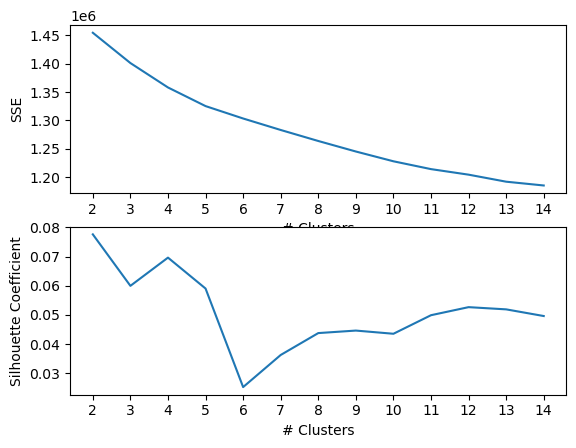

In [5]:
#Try Elbow Method
kmeans_kwargs = {
    "init": "random",
    "n_init": 40,
    "max_iter": 300
}

# A list holds the SSE values for each k
sse = []
# A list holds the silhouette coefficients for each k
silhouette_coeffs = []
tryks = 15 #max number of clusters to try

for k in range(2, tryks):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coeffs.append(score)
    
#Make Elbow plot, want turning point
plt.subplot(2, 1, 1)
plt.plot(range(2, tryks), sse)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("SSE")

#Make silhouette plot, want max score
plt.subplot(2, 1, 2)
plt.plot(range(2, tryks), silhouette_coeffs)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [6]:
#find elbow mathematically:
kl = KneeLocator(
    range(2, tryks), sse, curve="convex", direction="decreasing"
)

kelbow = kl.elbow
print(kelbow)

5


In [7]:
#find max cluster number mathematically
maxsc = max(silhouette_coeffs)
katmaxsc = silhouette_coeffs.index(maxsc)+2
print(katmaxsc)

2


Do these clusters correspond with any emotions?

In [8]:
#Run with k from elbow method:
kmeanselbow = KMeans(n_clusters=kelbow, **kmeans_kwargs)
elbowclusters = kmeanselbow.fit_predict(scaled_features)
#Run with k from silhouette coeffs method:
kmeanssil = KMeans(n_clusters=katmaxsc, **kmeans_kwargs)
silclusters = kmeanssil.fit_predict(scaled_features)

labels['elbow'] = elbowclusters
labels['silhouette'] = silclusters
print(labels)

     emotion  elbow  silhouette
0        ANG      4           0
1        SAD      2           0
2        ANG      3           1
3        SAD      2           0
4        ANG      3           1
...      ...    ...         ...
2528     HAP      1           0
2529     HAP      0           1
2530     SAD      2           0
2531     HAP      0           1
2532     HAP      1           0

[2533 rows x 3 columns]


C:\Users\USER\AppData\Local\Temp\ipykernel_8972\2770014292.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['elbow'] = elbowclusters
C:\Users\USER\AppData\Local\Temp\ipykernel_8972\2770014292.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['silhouette'] = silclusters


In [9]:
#now compare
emottotals = labels.groupby('emotion').size().reset_index(name='emottotals')

grouped0 = labels.groupby(['emotion', 'elbow']).size().reset_index(name='count')
grouped1 = labels.groupby(['emotion', 'silhouette']).size().reset_index(name='count')

merged0 = pd.merge(grouped0, emottotals, on='emotion')
merged0['percentage'] = (merged0['count'] / merged0['emottotals']) * 100

merged1 = pd.merge(grouped1, emottotals, on='emotion')
merged1['percentage'] = (merged1['count'] / merged1['emottotals']) * 100

print(merged1)

  emotion  silhouette  count  emottotals  percentage
0     ANG           0    405         887   45.659526
1     ANG           1    482         887   54.340474
2     HAP           0    414         832   49.759615
3     HAP           1    418         832   50.240385
4     SAD           0    409         814   50.245700
5     SAD           1    405         814   49.754300


With 2 groups, there is no differentiation between the emotions

In [10]:
print(merged0)

   emotion  elbow  count  emottotals  percentage
0      ANG      0    152         887   17.136415
1      ANG      1    199         887   22.435175
2      ANG      2      2         887    0.225479
3      ANG      3    323         887   36.414882
4      ANG      4    211         887   23.788050
5      HAP      0    200         832   24.038462
6      HAP      1    202         832   24.278846
7      HAP      2    203         832   24.399038
8      HAP      3    219         832   26.322115
9      HAP      4      8         832    0.961538
10     SAD      0    345         814   42.383292
11     SAD      1      5         814    0.614251
12     SAD      2    400         814   49.140049
13     SAD      3     62         814    7.616708
14     SAD      4      2         814    0.245700


With more groups, there is some differentiation. Let's get a better look.

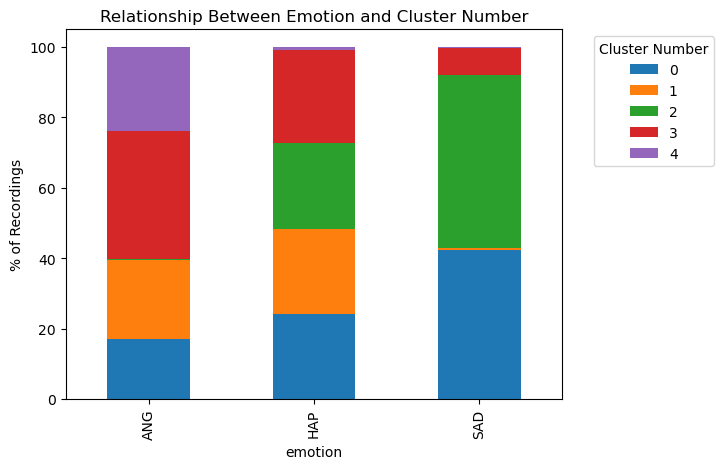

In [11]:
merged0['count'] = merged0['count'].astype(int) #avoid float error
merged0['elbow'] = merged0['elbow'].astype(str) #avoid float error

plotdf = merged0.pivot(index='emotion', columns='elbow', values='percentage').fillna(0)

plotdf.plot(kind='bar', stacked=True)
plt.title('Relationship Between Emotion and Cluster Number')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Do these clusters correspond with any languages?

In [12]:
#Run with k from elbow method:
kmeanselbow = KMeans(n_clusters=kelbow, **kmeans_kwargs)
elbowclusters = kmeanselbow.fit_predict(scaled_features)
#Run with k from silhouette coeffs method:
kmeanssil = KMeans(n_clusters=katmaxsc, **kmeans_kwargs)
silclusters = kmeanssil.fit_predict(scaled_features)

langdata['elbow'] = elbowclusters
langdata['silhouette'] = silclusters
print(langdata)

     language  elbow  silhouette
0         ENG      4           1
1         ENG      2           1
2         ITA      1           0
3         ENG      2           1
4         ITA      1           0
...       ...    ...         ...
2528      ENG      0           1
2529      EST      3           0
2530      ENG      2           1
2531      GER      3           0
2532      ENG      0           1

[2533 rows x 3 columns]


In [13]:
#now compare
langtotals = langdata.groupby('language').size().reset_index(name='langtotals')

groupedl0 = langdata.groupby(['language', 'elbow']).size().reset_index(name='count')
groupedl1 = langdata.groupby(['language', 'silhouette']).size().reset_index(name='count')

mergedl0 = pd.merge(groupedl0, langtotals, on='language')
mergedl0['percentage'] = (mergedl0['count'] / mergedl0['langtotals']) * 100

mergedl1 = pd.merge(groupedl1, langtotals, on='language')
mergedl1['percentage'] = (mergedl1['count'] / mergedl1['langtotals']) * 100

print(mergedl1)

  language  silhouette  count  langtotals  percentage
0      ENG           1   1199        1199  100.000000
1      EST           0    380         386   98.445596
2      EST           1      6         386    1.554404
3      FRE           0     94         108   87.037037
4      FRE           1     14         108   12.962963
5      GER           0    259         260   99.615385
6      GER           1      1         260    0.384615
7      GRE           0    362         362  100.000000
8      ITA           0    210         218   96.330275
9      ITA           1      8         218    3.669725


With 2 clusters, there does seem to be a difference between the languages.

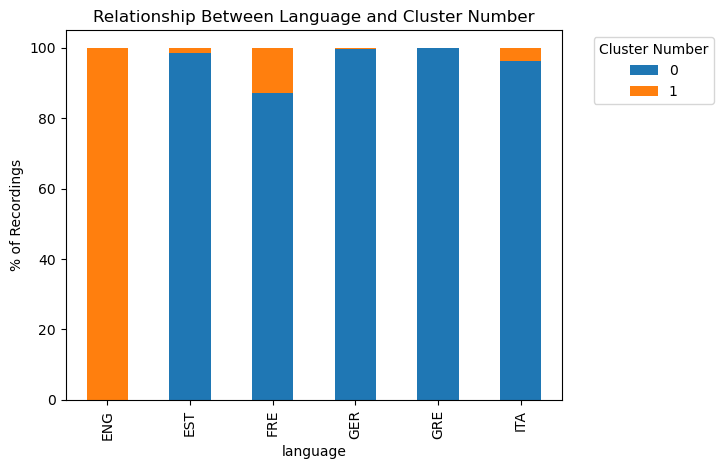

In [14]:
mergedl1['count'] = mergedl1['count'].astype(int) #avoid float error
mergedl1['silhoutte'] = mergedl1['silhouette'].astype(str) #avoid float error

plotdf = mergedl1.pivot(index='language', columns='silhouette', values='percentage').fillna(0)

plotdf.plot(kind='bar', stacked=True)
plt.title('Relationship Between Language and Cluster Number')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [15]:
print(mergedl0)

   language  elbow  count  langtotals  percentage
0       ENG      0    400        1199   33.361134
1       ENG      2    599        1199   49.958299
2       ENG      4    200        1199   16.680567
3       EST      1      1         386    0.259067
4       EST      2      1         386    0.259067
5       EST      3    375         386   97.150259
6       EST      4      9         386    2.331606
7       FRE      0      2         108    1.851852
8       FRE      1     93         108   86.111111
9       FRE      2      4         108    3.703704
10      FRE      3      7         108    6.481481
11      FRE      4      2         108    1.851852
12      GER      0      1         260    0.384615
13      GER      1    186         260   71.538462
14      GER      3     71         260   27.307692
15      GER      4      2         260    0.769231
16      GRE      1    243         362   67.127072
17      GRE      3    119         362   32.872928
18      ITA      1     88         218   40.366972


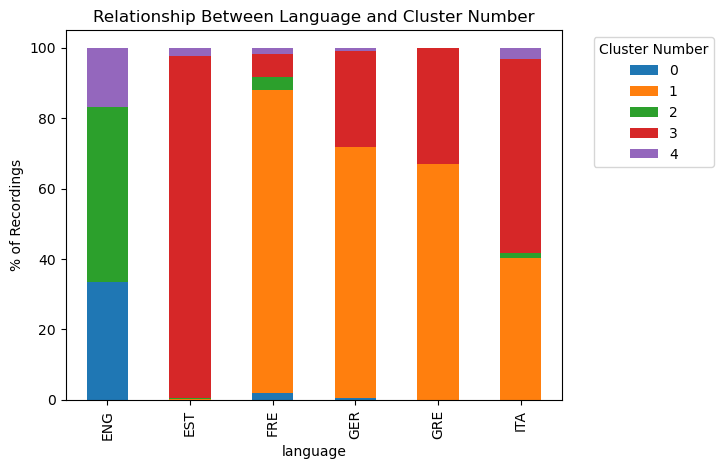

In [16]:
mergedl0['count'] = mergedl0['count'].astype(int) #avoid float error
mergedl0['elbow'] = mergedl0['elbow'].astype(str) #avoid float error

plotdf = mergedl0.pivot(index='language', columns='elbow', values='percentage').fillna(0)

plotdf.plot(kind='bar', stacked=True)
plt.title('Relationship Between Language and Cluster Number')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

There is a clear separation between languages. Honestly, since there is a column for each lanuage one-hot encoded, it actually has everything it needs to separate them out nicely. What happens if we redo this, but remove that information?

# Without Language Data

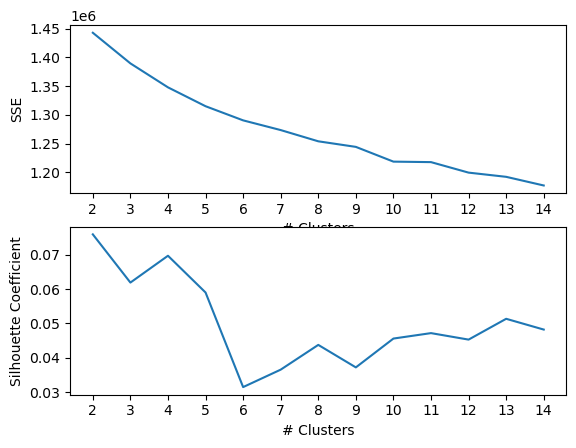

In [17]:
df2 = pd.get_dummies(dfin, columns=['gender'])
#drop the empty column at the beginning
df2 = df2.drop('Unnamed: 0',axis = 1)

#remove categorical columns except the column of interest, one gender. Remove language.
droplist= ['file_name', 'gender_M', 'sample_rate', 'bit_depth', 'language'] #since gender M is 100% linearly dependent of gender F and the technical stuff is not relevant
df2 = df2.drop(droplist, axis=1)
features2 = df2.drop(labcol, axis=1)
#Center and Scale
scaled_features2 = scaler.fit_transform(features2)

#make model for our input
#Try Elbow Method
kmeans_kwargs = {
    "init": "random",
    "n_init": 40,
    "max_iter": 300
}

# A list holds the SSE values for each k
sse2 = []
# A list holds the silhouette coefficients for each k
silhouette_coeffs2 = []
tryks = 15 #max number of clusters to try

for k in range(2, tryks):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features2)
    sse2.append(kmeans.inertia_)
    score = silhouette_score(scaled_features2, kmeans.labels_)
    silhouette_coeffs2.append(score)
    
#Make Elbow plot, want turning point
plt.subplot(2, 1, 1)
plt.plot(range(2, tryks), sse2)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("SSE")

#Make silhouette plot, want max score
plt.subplot(2, 1, 2)
plt.plot(range(2, tryks), silhouette_coeffs2)
plt.xticks(range(2, tryks))
plt.xlabel("# Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()



In [18]:
#find elbow mathematically:
kl2 = KneeLocator(
    range(2, tryks), sse2, curve="convex", direction="decreasing"
)
kelbow2 = kl2.elbow

#find max cluster number mathematically
maxsc2 = max(silhouette_coeffs2)
katmaxsc2 = silhouette_coeffs2.index(maxsc2)+2

Look for correlations with emotions

In [19]:
#Run with k from elbow method:
kmeanselbow2 = KMeans(n_clusters=kelbow2, **kmeans_kwargs)
elbowclusters2 = kmeanselbow2.fit_predict(scaled_features2)
#Run with k from silhouette coeffs method:
kmeanssil2 = KMeans(n_clusters=katmaxsc2, **kmeans_kwargs)
silclusters2 = kmeanssil2.fit_predict(scaled_features2)

labels['elbow2'] = elbowclusters2
labels['silhouette2'] = silclusters2
print(labels)

     emotion  elbow  silhouette  elbow2  silhouette2
0        ANG      4           0       6            0
1        SAD      2           0       0            0
2        ANG      3           1       9            1
3        SAD      2           0       8            0
4        ANG      3           1       9            1
...      ...    ...         ...     ...          ...
2528     HAP      1           0       7            0
2529     HAP      0           1       1            1
2530     SAD      2           0       8            0
2531     HAP      0           1       1            1
2532     HAP      1           0       7            0

[2533 rows x 5 columns]


C:\Users\USER\AppData\Local\Temp\ipykernel_8972\1174464912.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['elbow2'] = elbowclusters2
C:\Users\USER\AppData\Local\Temp\ipykernel_8972\1174464912.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['silhouette2'] = silclusters2


In [20]:
grouped02 = labels.groupby(['emotion', 'elbow2']).size().reset_index(name='count')
grouped12 = labels.groupby(['emotion', 'silhouette2']).size().reset_index(name='count')

merged02 = pd.merge(grouped02, emottotals, on='emotion')
merged02['percentage2'] = (merged02['count'] / merged02['emottotals']) * 100

merged12 = pd.merge(grouped12, emottotals, on='emotion')
merged12['percentage'] = (merged12['count'] / merged12['emottotals']) * 100

print(merged12)
print(merged02)

  emotion  silhouette2  count  emottotals  percentage
0     ANG            0    406         887   45.772266
1     ANG            1    481         887   54.227734
2     HAP            0    417         832   50.120192
3     HAP            1    415         832   49.879808
4     SAD            0    412         814   50.614251
5     SAD            1    402         814   49.385749
   emotion  elbow2  count  emottotals  percentage2
0      ANG       0      1         887     0.112740
1      ANG       1    138         887    15.558061
2      ANG       2      1         887     0.112740
3      ANG       4      6         887     0.676437
4      ANG       5     92         887    10.372041
5      ANG       6    205         887    23.111612
6      ANG       7    198         887    22.322435
7      ANG       8      1         887     0.112740
8      ANG       9    245         887    27.621195
9      HAP       0      1         832     0.120192
10     HAP       1    176         832    21.153846
11     HAP

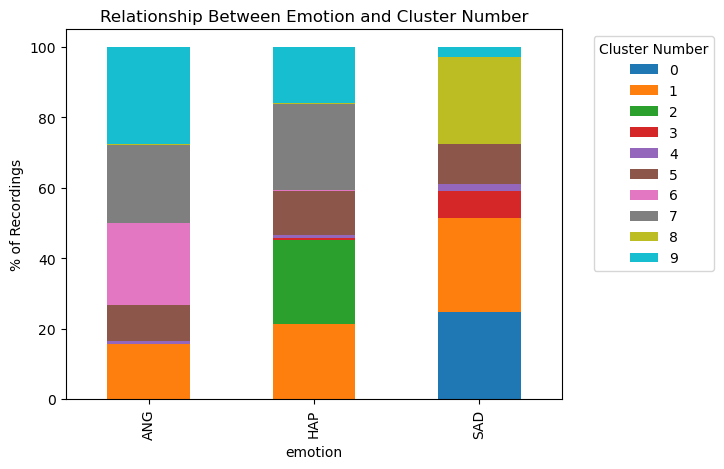

In [21]:
merged02['count'] = merged02['count'].astype(int) #avoid float error
merged02['elbow2'] = merged02['elbow2'].astype(str) #avoid float error

plotdf2 = merged02.pivot(index='emotion', columns='elbow2', values='percentage2').fillna(0)

plotdf2.plot(kind='bar', stacked=True)
plt.title('Relationship Between Emotion and Cluster Number')
plt.ylabel('% of Recordings')
plt.legend(title='Cluster Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Find important features

In [22]:
#Add the cluster number to the original data
features2['kcluster'] = elbowclusters2
# Calculate centroids
centroids = features2.groupby('kcluster').mean()
print(centroids)


          duration  syllabic_rate  zcr_mean   zcr_std  zcr_frequncy  \
kcluster                                                              
0         2.157637       0.465153  0.139381  0.217603      0.465153   
1         3.133508       0.425957  0.082892  0.076100      0.421332   
2         1.952861       0.514159  0.115849  0.157829      0.514159   
3         3.947866       0.299487  0.072641  0.088698      0.293543   
4         6.468748       0.168787  0.060823  0.086745      0.168787   
5         3.615774       0.311263  0.138259  0.124856      0.310135   
6         1.441389       0.715864  0.098795  0.100548      0.715864   
7         1.940632       0.520030  0.201648  0.228123      0.520030   
8         2.491851       0.403704  0.092022  0.140223      0.403704   
9         2.508416       0.436528  0.142633  0.106935      0.436528   

          mean_spectral_envelope  median_spectral_envelope  \
kcluster                                                     
0                    25

In [23]:
#Use ANOVA to find the important features
anova_results = {}
for feature in features2.columns[:-1]:  # exclude the 'Cluster' column
    groups = [features2[features2['kcluster'] == cluster][feature] for cluster in features2['kcluster'].unique()]
    anova_results[feature] = f_oneway(*groups)

#We have so many tests. Do a Bonferroni correction
num_tests = len(anova_results)
p_values = [anova_results[feature].pvalue for feature in anova_results]
corrected_p_values = np.minimum(np.array(p_values) * num_tests, 1.0)  # Bonferroni correction


# Display the results
anova_results_df = pd.DataFrame(anova_results, index=['F-Statistic', 'P-Value']).T
anova_results_df['Bonf Ps'] = corrected_p_values
print(anova_results_df.sort_values(by='Bonf Ps'))

C:\Users\USER\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


                                     F-Statistic  P-Value  Bonf Ps
gender_F                              329.562836      0.0      0.0
zcr_stds_diffs_0_1                   1107.094239      0.0      0.0
max_amp_short_2                       290.472441      0.0      0.0
min_amp_short_2                       244.911137      0.0      0.0
zcr_diffs_from_average0_1            1957.855869      0.0      0.0
...                                          ...      ...      ...
frequncys_zcr_diff                           NaN      NaN      NaN
zcr_frequncys_diffs_from_average0_1          NaN      NaN      NaN
zcr_frequncys_diffs_from_average1_2          NaN      NaN      NaN
zcr_frequncys_diffs_from_average2_3          NaN      NaN      NaN
zcr_frequncys_diffs_from_average3_4          NaN      NaN      NaN

[619 rows x 3 columns]


In [24]:
anova_results_df.sort_values(by='Bonf Ps')[480:500]

,F-Statistic,P-Value,Bonf Ps
max_amp_short_2_grad,12.002009,9.951106e-19,6.159735e-16
mean_amp_short_0_diff,11.746792,2.790389e-18,1.727250e-15
f0_short_0_diff,11.675198,3.725915e-18,2.306341e-15
maxsumf_short/meancent_short_1_diff,11.383938,1.207368e-17,7.473608e-15
cliprangef0_short_2_grad,11.301852,1.681406e-17,1.040790e-14
maxpf_short/maxpf_short_2_grad,11.293215,1.741018e-17,1.077690e-14
maxpf_short_2_grad,11.293215,1.741018e-17,1.077690e-14
maxsumf_short/meancent_short_2_diff,11.255693,2.025529e-17,1.253802e-14
cliprangef0_short_1_grad,10.777611,1.391318e-16,8.612261e-14
maxf_items_short_2_diff,10.748693,1.563167e-16,9.676006e-14


Even with the Bonferroni adjustment and setting a low threshold, there are still a lot of "statistically significant" features between the groups.
Let's just look at the top 20 to get an idea of what is likely to be important.

In [25]:
anova_results_df.sort_values(by='Bonf Ps')[0:20]

,F-Statistic,P-Value,Bonf Ps
gender_F,329.562836,0.0,0.0
zcr_stds_diffs_0_1,1107.094239,0.0,0.0
max_amp_short_2,290.472441,0.0,0.0
min_amp_short_2,244.911137,0.0,0.0
zcr_diffs_from_average0_1,1957.855869,0.0,0.0
zcr_from_average2,491.358375,0.0,0.0
zcr_from_average1,379.133117,0.0,0.0
zcr_from_average0,2159.045980,0.0,0.0
mean_zcr_diff,703.749039,0.0,0.0
mean_zcr,463.088673,0.0,0.0


In [30]:
collist = anova_results_df.sort_values(by='Bonf Ps')[0:20].index[1:20].tolist() #gender is categorical

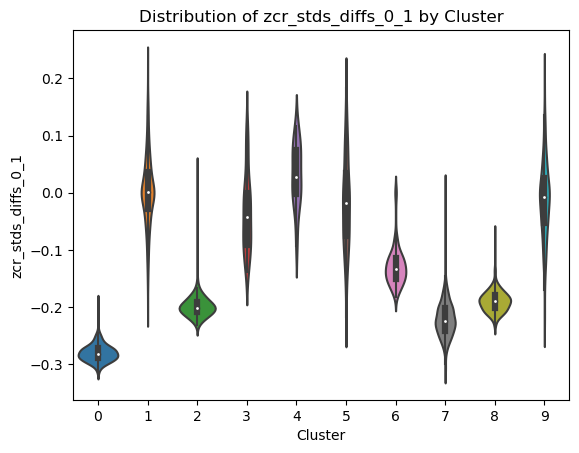

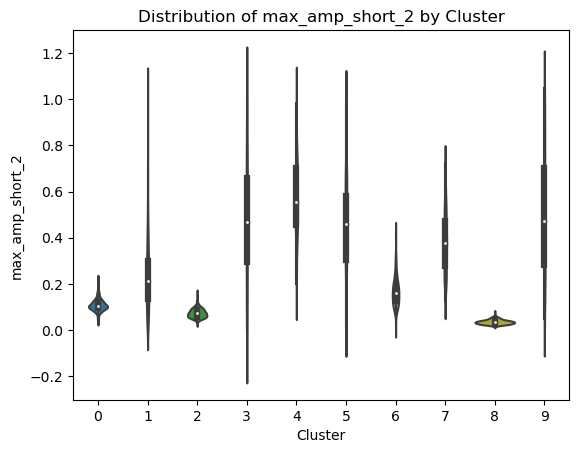

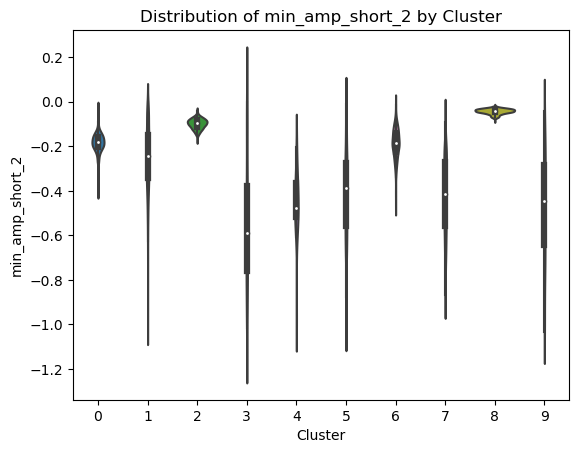

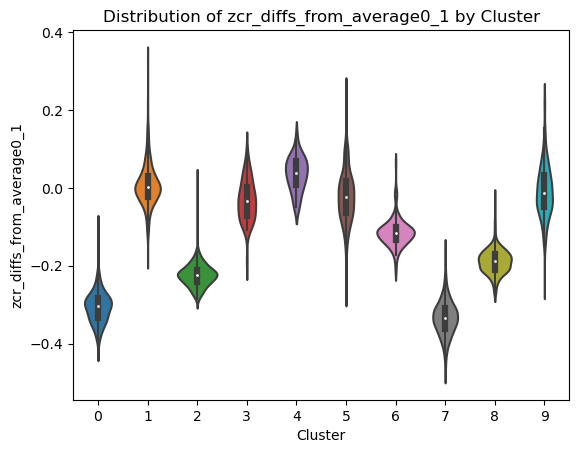

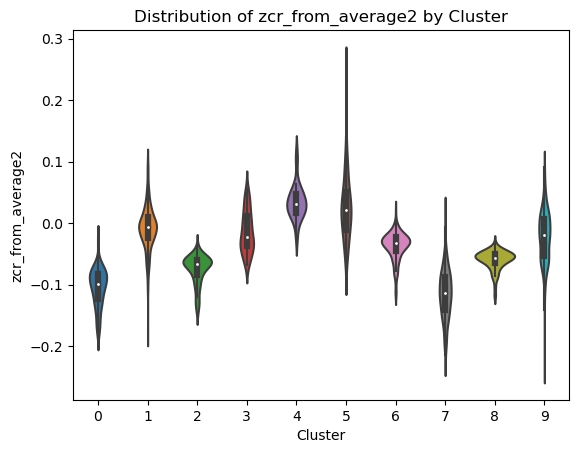

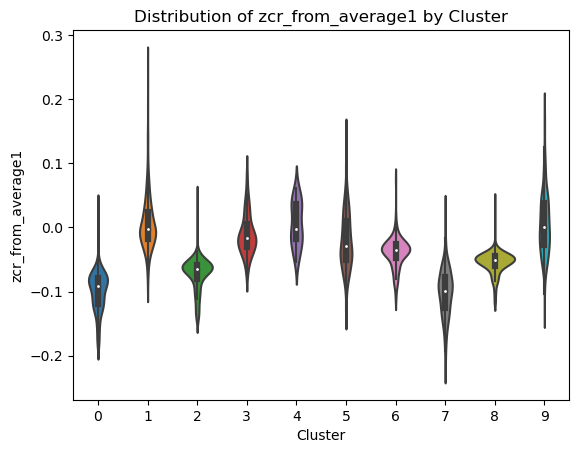

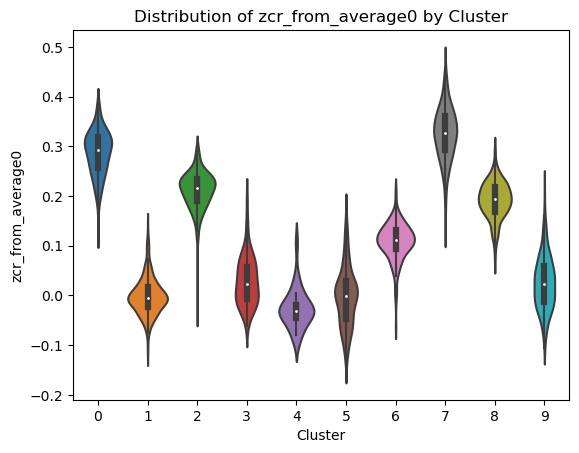

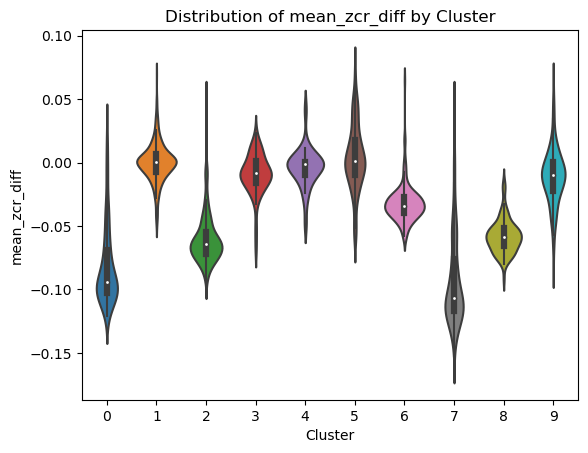

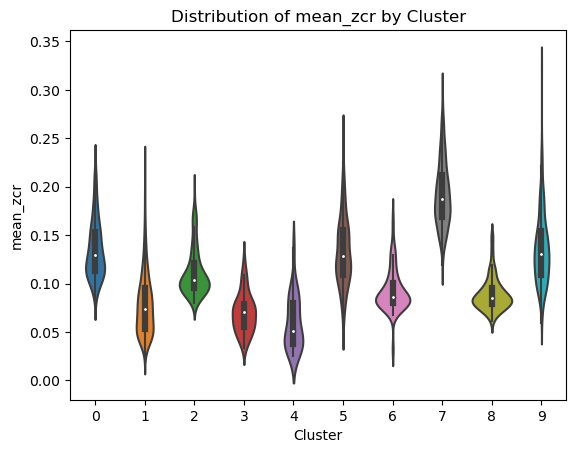

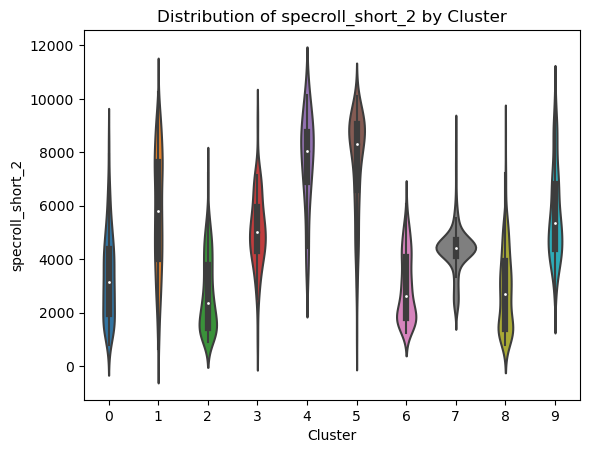

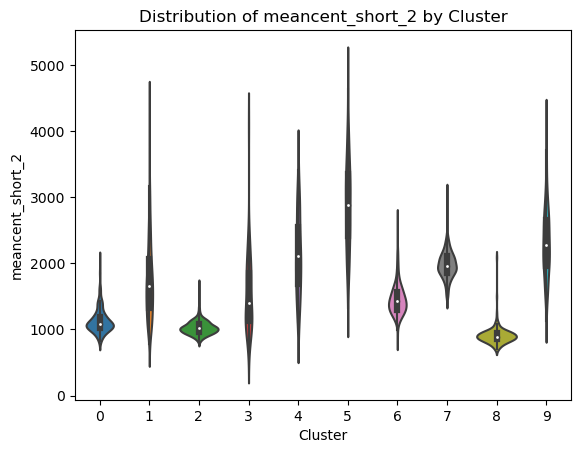

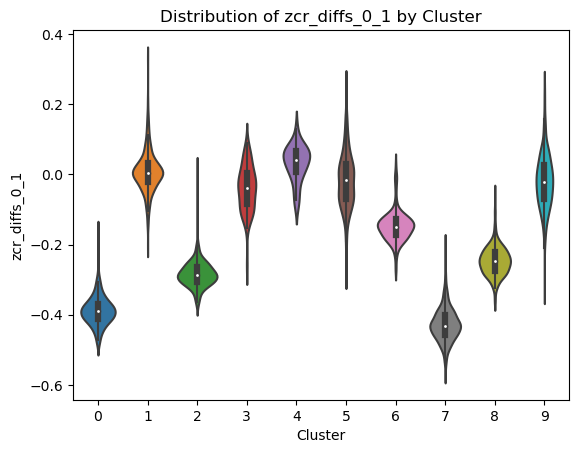

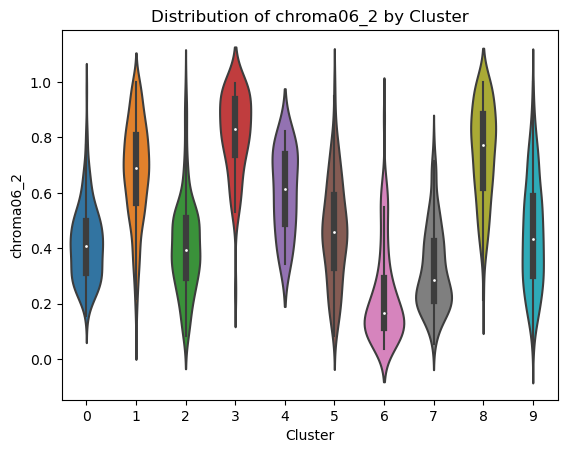

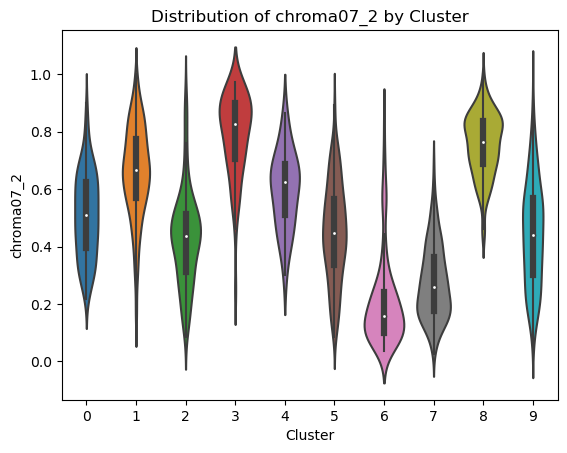

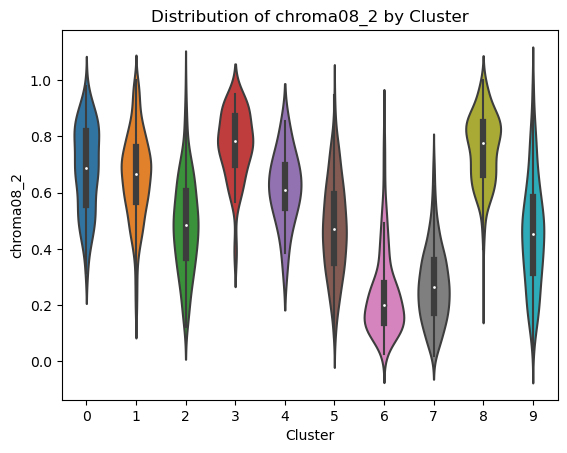

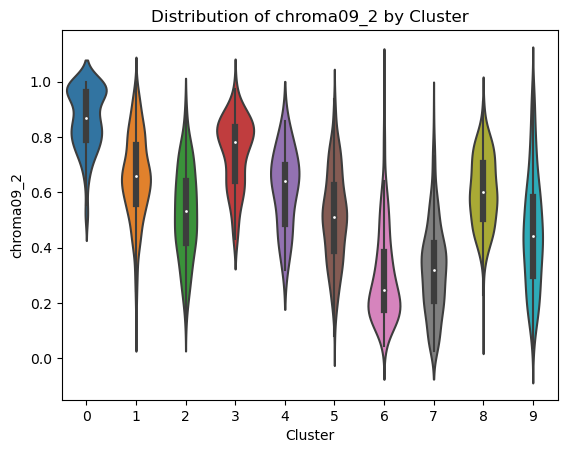

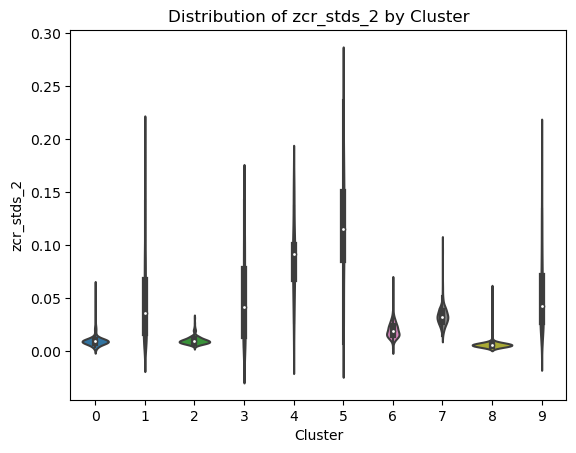

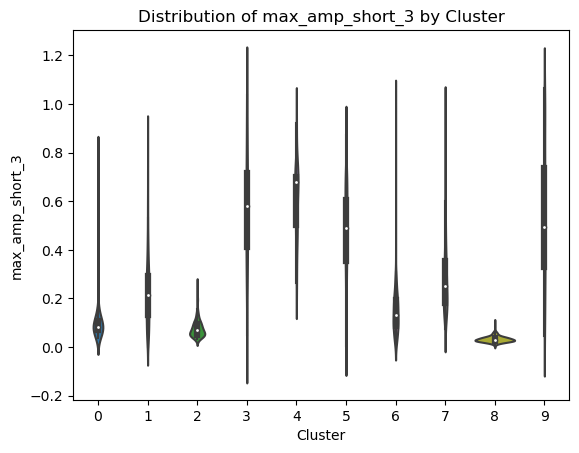

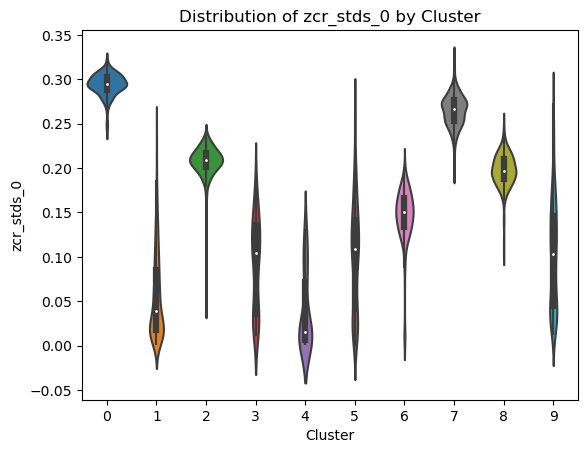

In [31]:
for column in collist:
    #plt.figure(figsize=(10, 6))
    sns.violinplot(x='kcluster', y=column, data=features2)
    plt.title(f'Distribution of {column} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()